In [1]:
# SimpliPyTEM particle analysis
# Modified from the Particle Analysis Tutorial at https://simplipytem.readthedocs.io/en/latest/Tutorials/Particle_analysis_tutorial.html
# Gabriel Ing. Revision 268675b5

# Adapted notebook MW Fay for nmRC 
# Acknowledgements to Leigh Fung, Mehul Singh, Julie Watts, Ben Weare

# This package will take approximately two to three minutes to run on a standard dm4 file
# The end parameters can be used for batch processing


In [2]:
#Import dependancies 

In [3]:
from SimpliPyTEM.Micrograph_class import Micrograph

<Figure size 640x480 with 0 Axes>

In [4]:
#This particle analysis module contains the functions suitable for performing this type of particle analysis from a dm4 file
from SimpliPyTEM.Particle_analysis import Threshold, Find_contours, Collect_particle_data


<Figure size 640x480 with 0 Axes>

In [5]:
#Import matplotlib to plot the data
import matplotlib.pyplot as plt

In [6]:
#numpy for arrays and mathematical operations
import numpy as np


In [7]:
# Import PIL for exporting histograms as tifs
from PIL import Image
import io

In [8]:
#File list
#Can specify a list

# Network drive files
files = ['//nmrc-nas.nottingham.ac.uk/data/Instrument Data/2100Plus/LowkV/80 60 40 20 at 250kx Ultrascan/PdAu calib 169_US1000XP_80kV_250kX_49864.dm4.dm4',
         '//nmrc-nas.nottingham.ac.uk/data/Instrument Data/2100Plus/LowkV/80 60 40 20 at 250kx Ultrascan/PdAu calib 169_US1000XP_60kV_250kX_49872.dm4.dm4',
         '//nmrc-nas.nottingham.ac.uk/data/Instrument Data/2100Plus/LowkV/80 60 40 20 at 250kx Ultrascan/PdAu calib 169_US1000XP_40kV_250kX_49890.dm4.dm4',
         '//nmrc-nas.nottingham.ac.uk/data/Instrument Data/2100Plus/LowkV/80 60 40 20 at 250kx Ultrascan/PdAu calib 169_US1000XP_40kV_250kX_49886.dm4.dm4'
         ]


'''
files = ['D:/work on D/scripts/Python tests and edits/PdAu calib 169_US1000XP_60kV_250kX_49872.dm4.dm4',
         'D:/work on D/scripts/Python tests and edits/PdAu calib 169_US1000XP_60kV_250kX_49872.dm4.dm4',
         'D:/work on D/scripts/Python tests and edits/PdAu calib 169_US1000XP_60kV_250kX_49872.dm4.dm4',
         'D:/work on D/scripts/Python tests and edits/PdAu calib 169_US1000XP_60kV_250kX_49872.dm4.dm4'
        ]
'''        

"\nfiles = ['D:/work on D/scripts/Python tests and edits/PdAu calib 169_US1000XP_60kV_250kX_49872.dm4.dm4',\n         'D:/work on D/scripts/Python tests and edits/PdAu calib 169_US1000XP_60kV_250kX_49872.dm4.dm4',\n         'D:/work on D/scripts/Python tests and edits/PdAu calib 169_US1000XP_60kV_250kX_49872.dm4.dm4',\n         'D:/work on D/scripts/Python tests and edits/PdAu calib 169_US1000XP_60kV_250kX_49872.dm4.dm4'\n        ]\n"

In [9]:
# Alternatively use glob

useglob = False

if useglob == True:

    import glob
    # All files and directories ending with .dm4 and that don't begin with a dot:
    files = (glob.glob("//nmrc-nas.nottingham.ac.uk/data/Instrument Data/2100Plus/LowkV/80 60 40 20 at 250kx Ultrascan/*.dm4")) 

In [10]:
#Titles list
titles = ['Ultrascan_80kV',
          'Ultrascan_60kV',
          'Ultrascan_40kV',
          'Ultrascan_40kV_2'
         ]

In [11]:
#Select file
FileNo = 1
im = Micrograph(files[FileNo])

//nmrc-nas.nottingham.ac.uk/data/Instrument Data/2100Plus/LowkV/80 60 40 20 at 250kx Ultrascan/PdAu calib 169_US1000XP_60kV_250kX_49872.dm4.dm4 opened as a Micrograph object


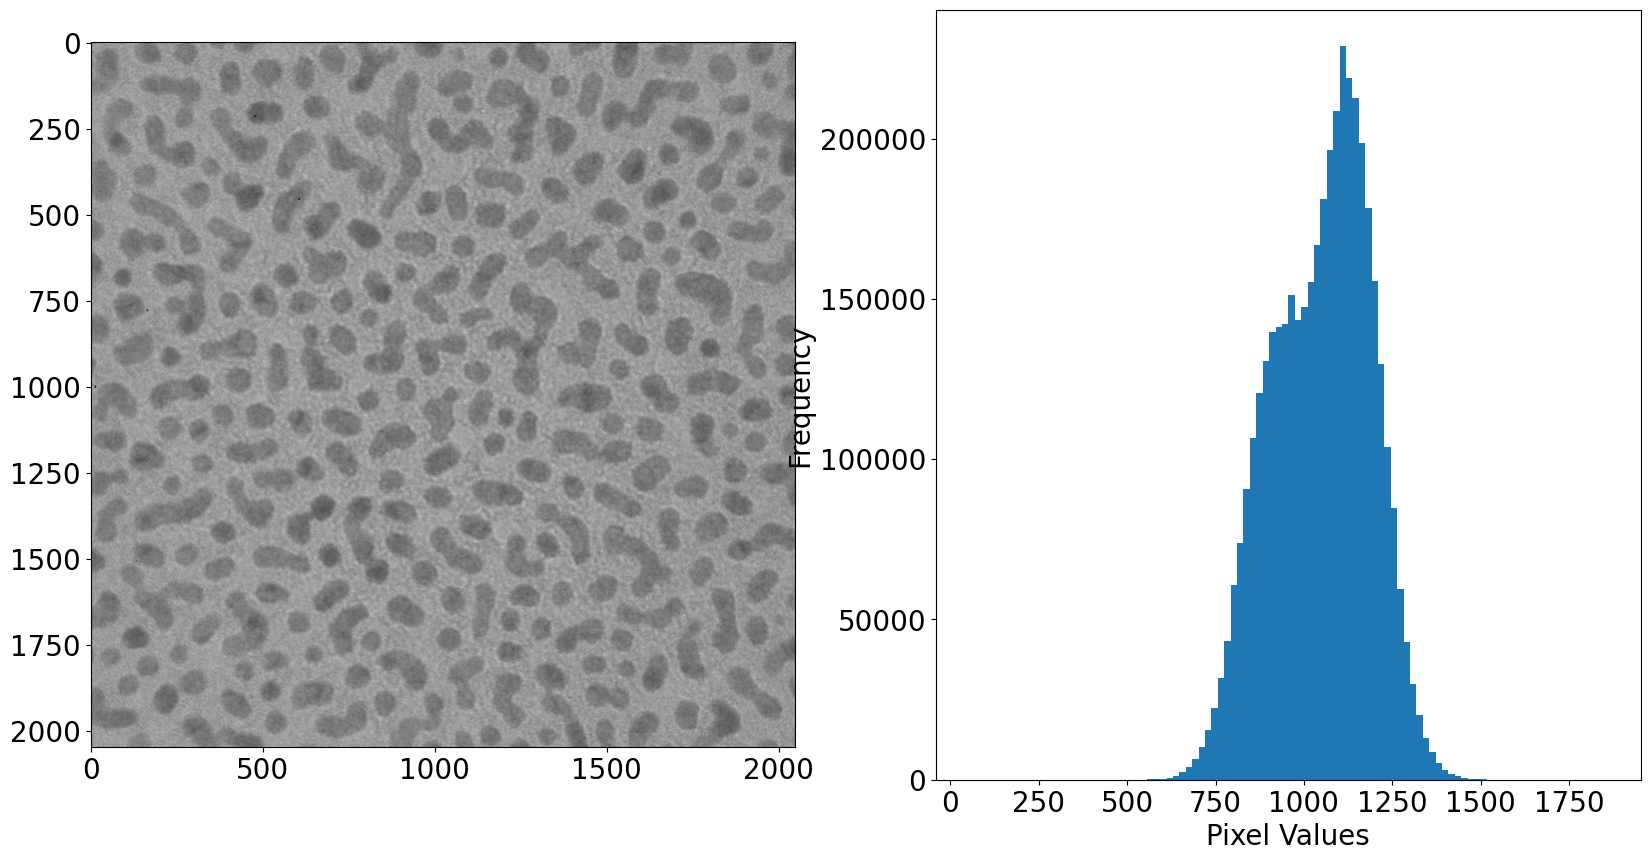

In [12]:
#Histogram
im.plot_histogram(sidebyside=True)


## Local Normalisation

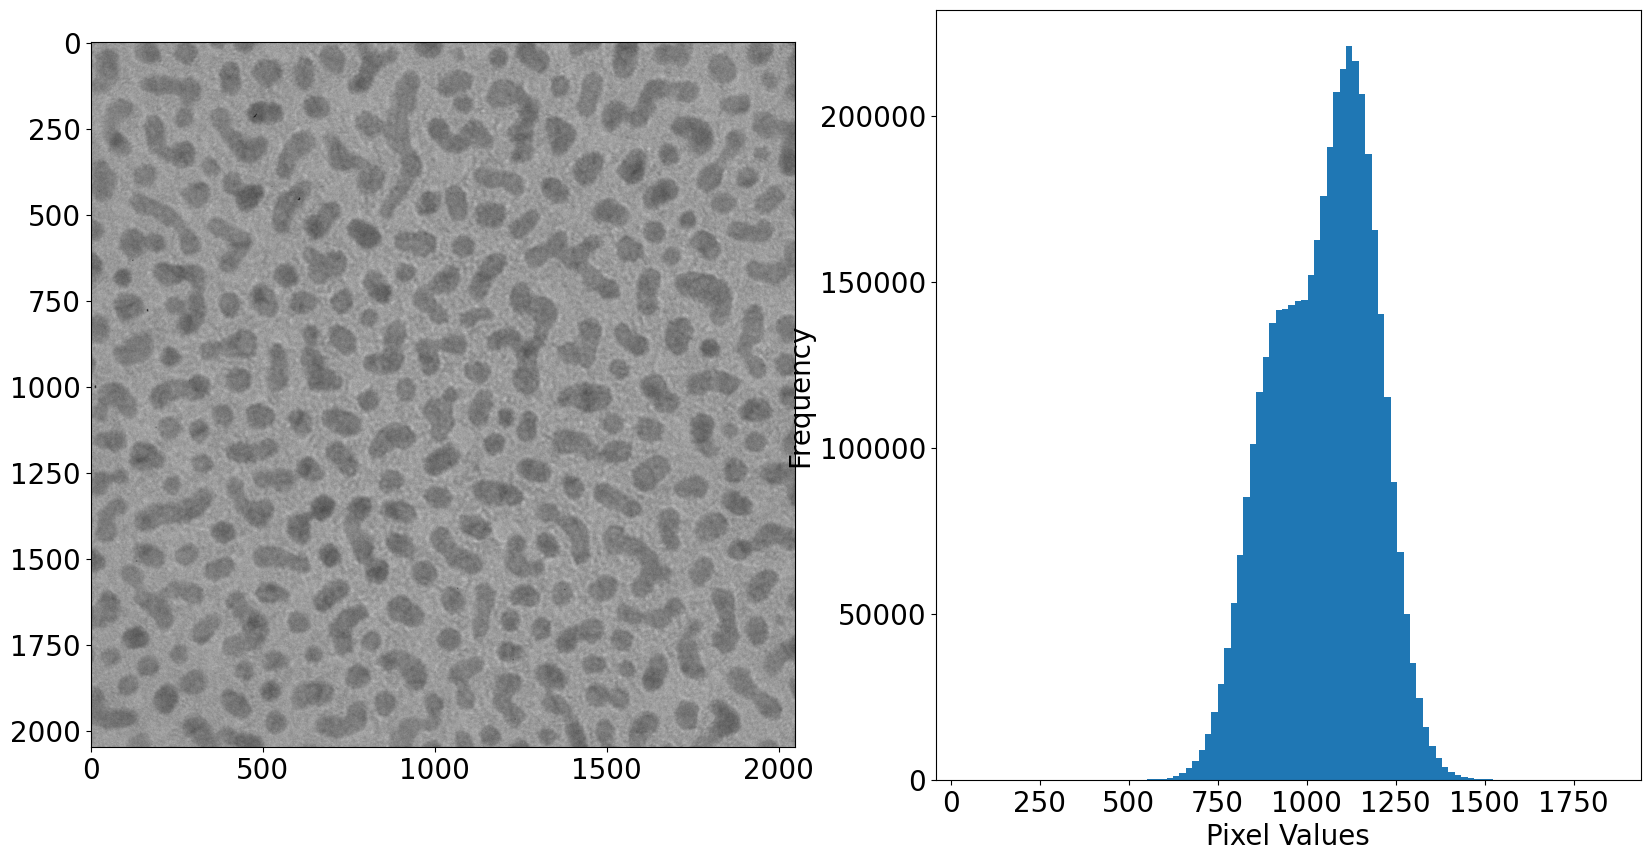

In [42]:
# Processing - local normalisation to compensate for any intensity variation across image
lnormval = 6
imp = im.local_normalisation(lnormval)
imp.plot_histogram(sidebyside=True)

## Gaussian filter

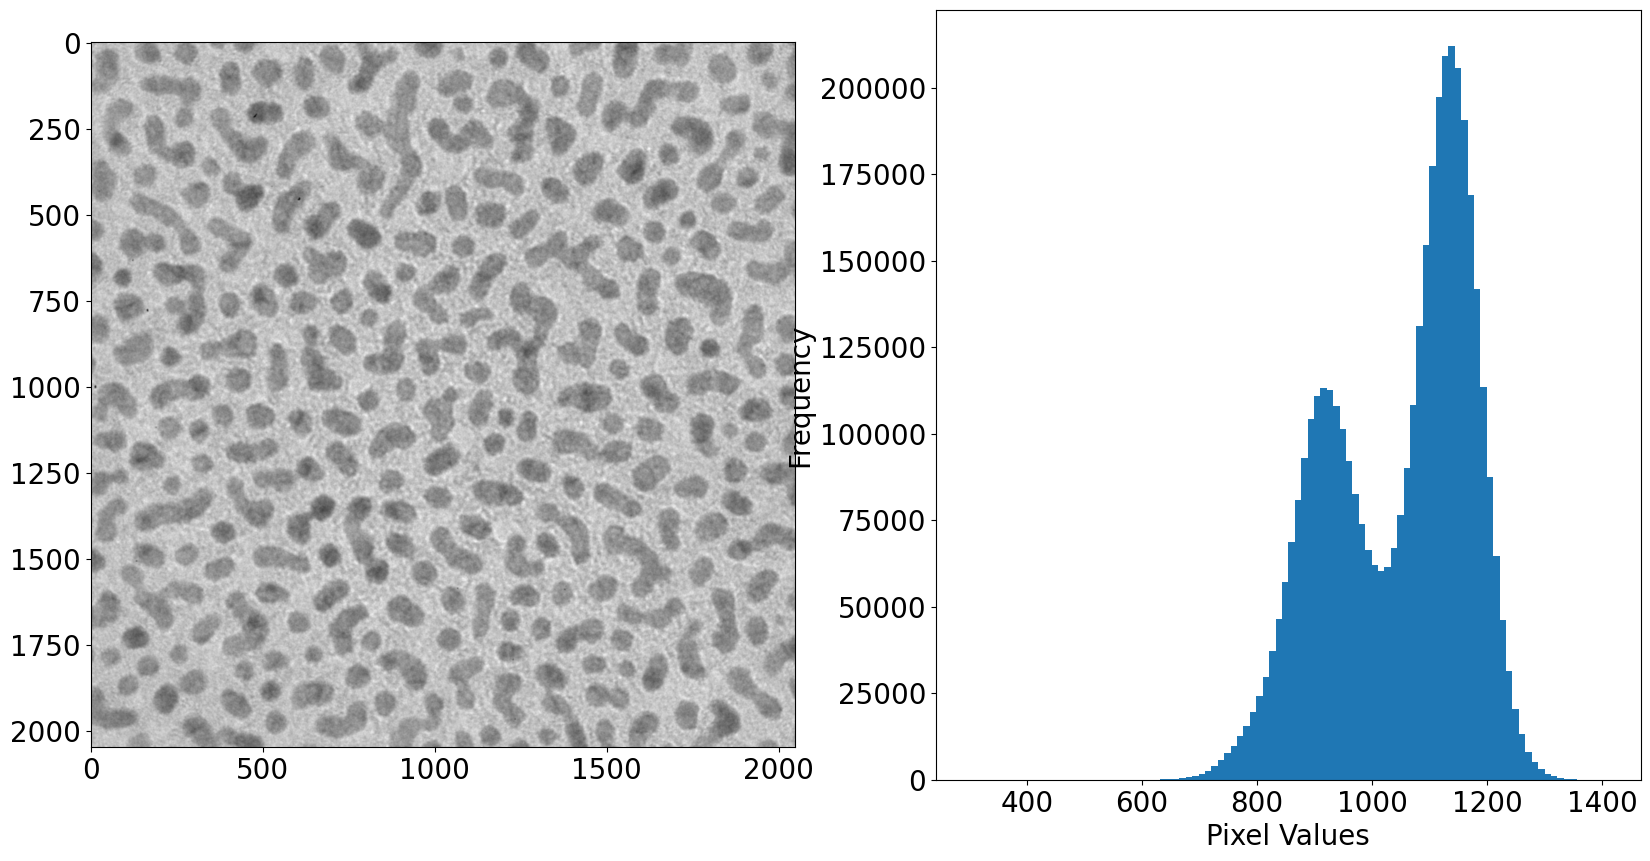

In [14]:
#Apply gaussian - aim is to improve bimodal contrast in histogram, without losing resolution excessively
imp_gaussian= imp.gaussian_filter(7)
imp_gaussian.plot_histogram(True)

## Recalculate histogram using scipy.ndimage directly, so data can be analysed

In [15]:
# Want to process information from histogram rather than just visualise it, so use scipy.ndimage on image from micrograph

In [16]:
from scipy import ndimage
#histT = ndimage.histogram(imp_gaussian.image, min = 0, max = 2000, bins = 255)
histT = ndimage.histogram(imp_gaussian.image, min = 0, max = imp_gaussian.image.max(), bins = int(imp_gaussian.image.max()))


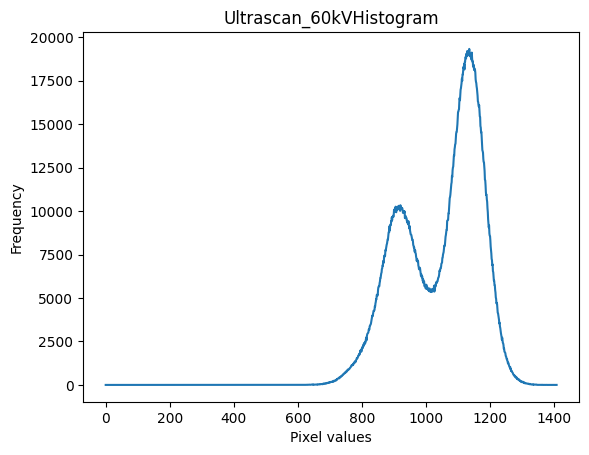

In [17]:
figHT, ax = plt.subplots()
ax.set_title(titles[FileNo]+"Histogram")
ax.set_xlabel("Pixel values")
ax.set_ylabel("Frequency")
#ax.set_xlim([0.0, 1500])  # <- named arguments do not work here
#ax.plot(histogram)  # <- or here
#ax.plot(hist1)  # <- or here
ax.plot(histT)  # <- or here

In [18]:
# Save histogram as image and data formats
# Image format
figHT.savefig(titles[FileNo]+'IntensityHistogram_FromTIF.png', dpi=200)

# Raw format
# hist2 is an array of dtype int64
outfile = titles[FileNo]+' IntensityHistogram'
np.save(outfile, histT)

## Identify peaks and valley, use valley to set threshold value

In [19]:
# Identify the peaks and valley - should be two peaks

from scipy.signal import find_peaks
peaks, _ = find_peaks(histT, width=20)

peaks


array([ 921, 1136], dtype=int64)

In [20]:
# And one valley, if the prominence filter is set correctly
valley, _ = find_peaks(-histT, width=20, prominence = 500)
valley

array([1017], dtype=int64)

In [21]:
# Use this valley to set the threshold

vall = valley[0]

thresh = Threshold(imp_gaussian.image, vall) # threshold value based on valley in histogram from SimpliPyTEM which is not the same as the bodge histogram output from TIF

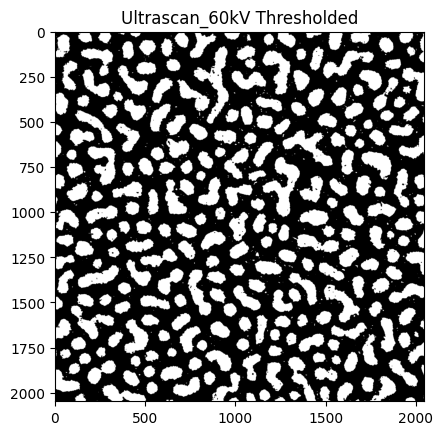

In [22]:
plt.imshow(thresh)
plt.title(titles[FileNo]+' Thresholded')
plt.show()

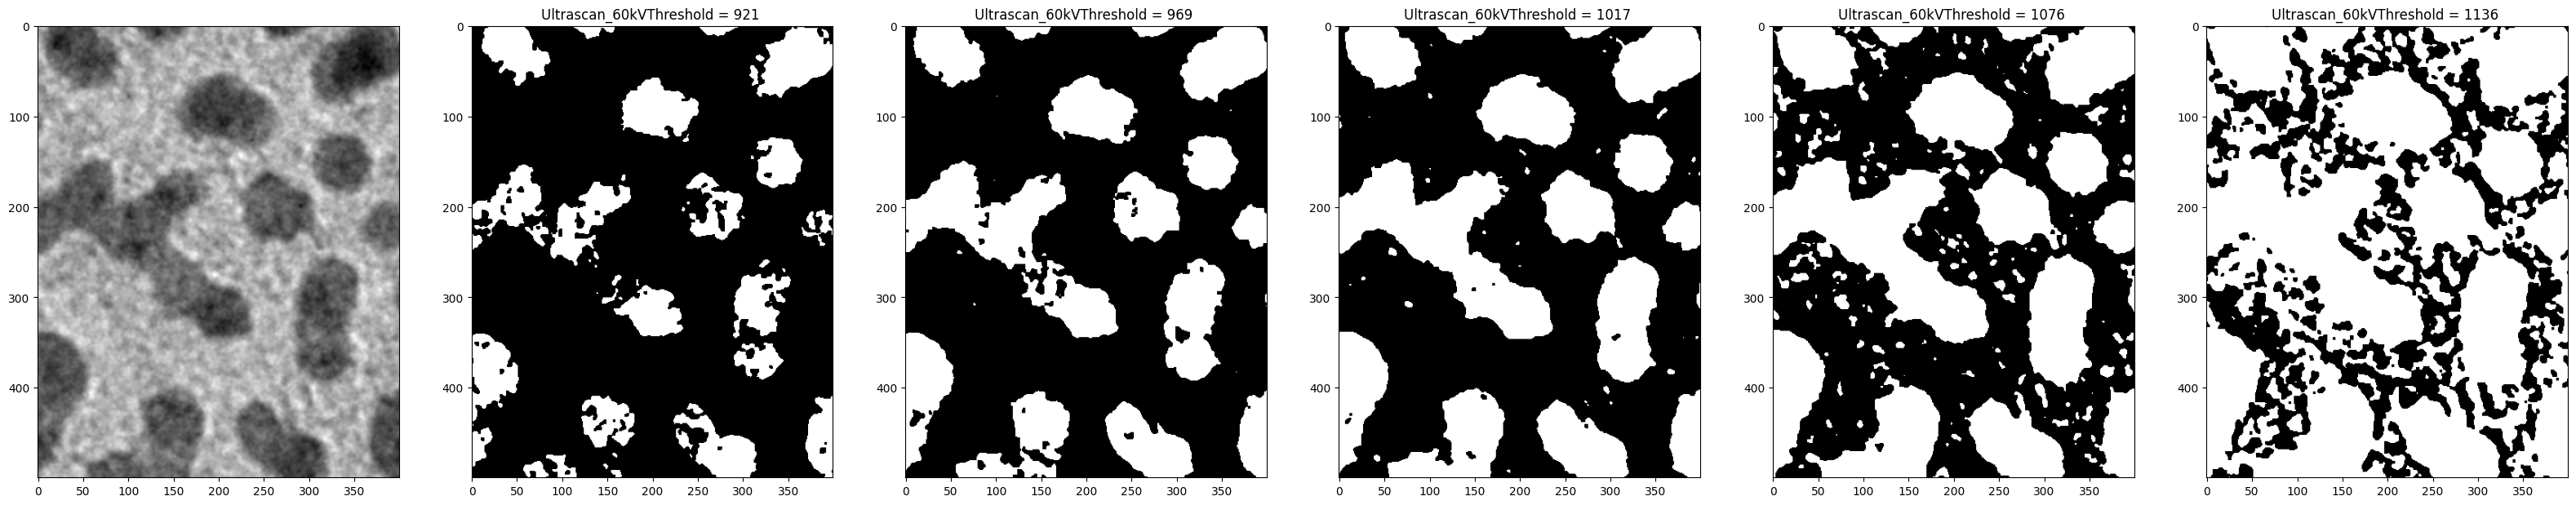

In [23]:
#local zoom in, check valley threshold guess - middle of the five thresholds below - looks good

thresholds = [peaks[0], int(0.5*(valley[0]+peaks[0])), valley[0], int(0.5*(peaks[1]+valley[0])), peaks[1]]

fig, ax = plt.subplots(1,6, figsize =(40,10))
ax[0].imshow(imp_gaussian.image[400:900, 1300:1700])
for i in range(len(thresholds)):
    ax[i+1].imshow(Threshold(imp_gaussian.image, thresholds[i])[400:900, 1300:1700])
    ax[i+1].set_title(titles[FileNo]+'Threshold = {} '.format(thresholds[i]))

plt.show()

In [24]:
# small amount of surrounding noise will be okay, as picking high contrast extended features for particles

# Uncomment here to allow input of threshold value
#threshold = input(vall[0])
#threshold = int(threshold)
#print('Threshold will be '+str(threshold))

#If the valley looks good, just use it
threshold = valley[0]

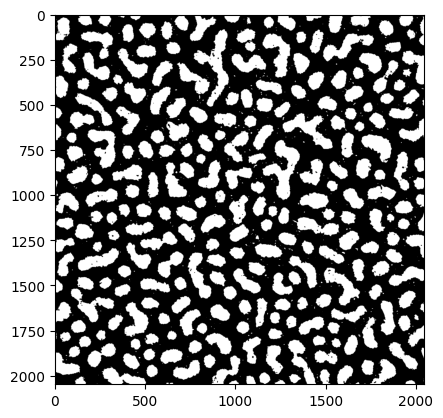

In [25]:
thresh= Threshold(imp_gaussian.image, threshold)
plt.imshow(thresh)
plt.show()

# Locate particles

In [26]:
# Parameters to enter -
# minsize = minimum size in pixels
# threads - number of threads, 5 is default, more may be optimal depending on system run on


In [27]:
# So what size of pixels do we want to discount?
# Check image pixel size
print('Pixel size is '+str(imp_gaussian.pixel_size))

print('1 nm is '+str(1/imp_gaussian.pixel_size)+' pixels')

PixWd = 50

Pixel size is 0.0442272387444973
1 nm is 22.610500415299356 pixels


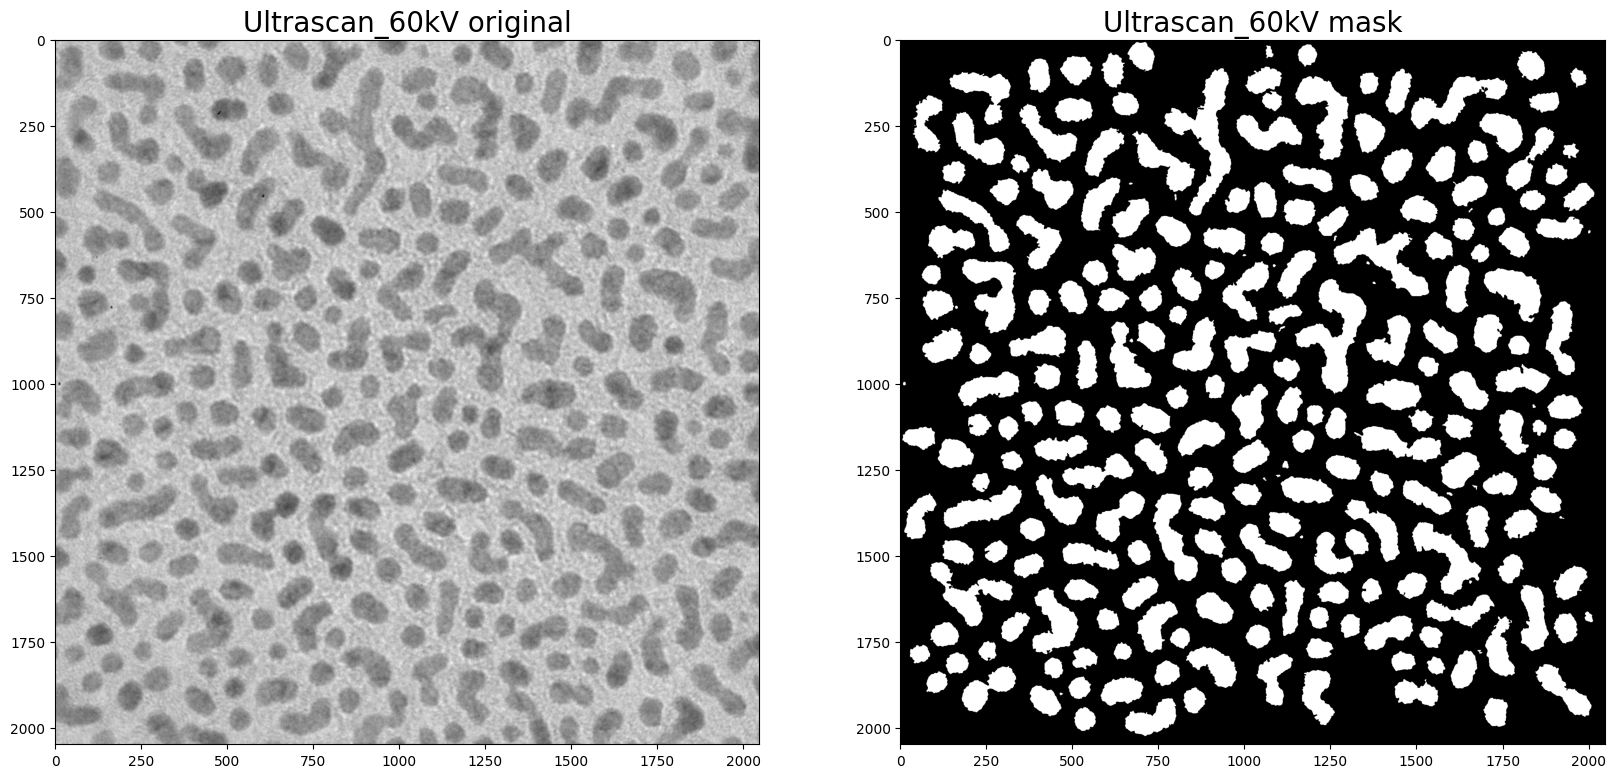

In [28]:
contours_im, mask =Find_contours(thresh, minsize=PixWd)

imp_gaussian.show_pair(mask, title1=titles[FileNo]+' original', title2=titles[FileNo]+' mask')

# Collecting and plotting particle data

In [29]:
#Change to nm if necessary
#imp_gaussian.change_scale_unit('nm')
#print(imp_gaussian.pixel_size, imp_gaussian.pixel_unit)

In [30]:
data = Collect_particle_data(contours_im, imp_gaussian.pixel_size)

# save data as a file, same folder as jupyter notebook is run from
import json

with open(titles[FileNo]+'data.json', 'w') as fp:
    json.dump(data, fp)

In [31]:
print(data.keys())

dict_keys(['Area', 'Centroid', 'Centroid_x', 'Centroid_y', 'Perimeter', 'Circularity', 'Width', 'Height', 'Radius', 'Major-Minor Ratio'])


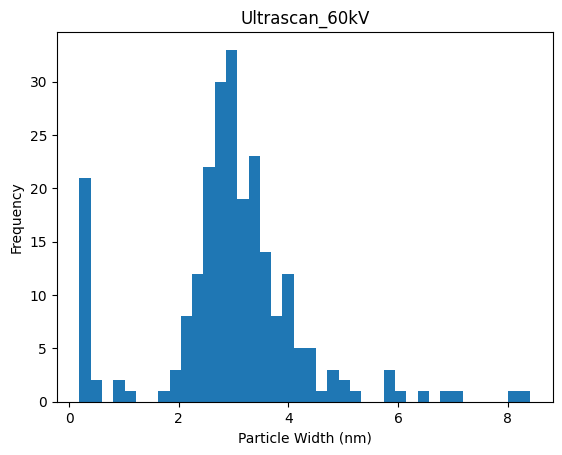

In [32]:
# Plot width distribution using matplotlib
fig = plt.figure()
plt.hist(data['Width'], bins=40)
plt.xlabel('Particle Width ('+imp_gaussian.pixel_unit+')')
plt.ylabel('Frequency')
plt.title(titles[FileNo])
plt.show()



In [33]:
fig.savefig(titles[FileNo]+'ParticleSizing.png', dpi=200)
# This saves as a png in the folder the jupyter file is running from

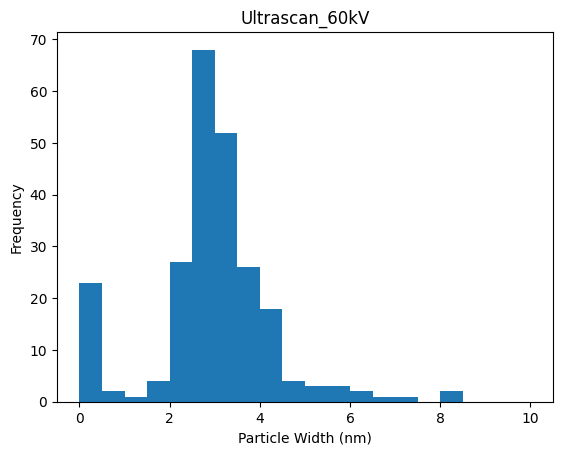

In [34]:
# Plot width distribution using matplotlib, using fixed bins
fig2 = plt.figure()
binwidth = 0.5
#plt.hist(data['Width'], bins=range(0, int(10 + binwidth), int(binwidth)))
plt.hist(data['Width'], bins=np.arange(0, 10 + binwidth, binwidth))
plt.xlabel('Particle Width ('+imp_gaussian.pixel_unit+')')
plt.ylabel('Frequency')
plt.title(titles[FileNo])
plt.show()
fig2.savefig(titles[FileNo]+'ParticleSizing_2.png', dpi=200)

In [35]:
#create lists to store data
masks = []
alldata = []


In [36]:
#Save the data to the empty lists we created
alldata.append(data)
masks.append(mask)

In [37]:
#import the function
from SimpliPyTEM.Particle_analysis import Convert_to_single_dict
alldata_dict = Convert_to_single_dict(alldata, combine_data=False)

In [38]:
import pandas as pd
df = pd.DataFrame(alldata_dict)

In [39]:
#Lets have a look at the result - this prints the first 5 lines
df.head()

Area  \
0  [8.454042252173062, 0.10660465125947058, 12.72...   

                                            Centroid  \
0  [(57.62536634274255, 1157.3447478019436), (12....   

                                          Centroid_x  \
0  [57.62536634274255, 12.314984709480122, 54.283...   

                                          Centroid_y  \
0  [1157.3447478019436, 1000.6758409785932, 1387....   

                                           Perimeter  \
0  [12.845836466598866, 1.2339176159193221, 18.94...   

                                         Circularity  \
0  [0.5838344695421974, 0.7153477535262274, 0.409...   

                                               Width  \
0  [2.963224995881319, 0.3095906712114811, 3.1925...   

                                              Height  \
0  [4.157360441982746, 0.3980451487004757, 6.2909...   

                                              Radius  \
0  [2.146902909784984, 0.2177983231317775, 3.1455...   

                                   Major-Minor Ratio  \
0  [1.4029850746268657, 1.2857142857142858, 1.970...   

                                        Image number  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [40]:
df.to_csv(titles[FileNo]+'Particle_data.csv')

In [44]:
#List parameters used for batch processing purposes

print ('\n Local normalisation value: ' +str(lnormval))
print ('\n automated threshold value: ' +str(vall))
print ('\n used threshold value: ' +str(threshold))
print ('\n minimum Pixel width: ' +str(PixWd))


 Local normalisation value: 6

 automated threshold value: 1017

 used threshold value: 1017

 minimum Pixel width: 50
